# Alignments
* Some alignments were done externally on Google Colab using `align_sents` from `script/post_processing.py`, it uses our `bertalign` fork
* A 'triplet' in this project refers to JSONL files in format 
```
{"mt":"Hello World!" "ref":"Hello World!", "src":"Hallo Welt!"}
```
* Alignment refers to using bertalign to align two texts together, in this case, we always align source texts with either referece text or machine translation.
* We create triplets by using source text as key to join it together with reference and translation
* **Direct Triplets**: We assume that translations preserved alignments and create tripets directly.
* **Aligned Triplets without sentence splitting**: bertalign was used to align source to machine translation with `is_split=True`, which means the whole string is embedded into a vector for cosine similarity and bertalign tries to align these strings. So we will never have more than 400 aligned strings
* **Aligned Triplets WITH sentence splitting**: `is_split=False` will make bertalign use Sentence Splitting, can potentially create more than 400 aligned sentences, since not each string consists of a single sentence. 
    * Example: FLORES+ is English texts translated into other languages. 400 English sentences correspond to around 431 German or French sentences, which means we have one-to-many alignments. If we thus try to align German to French or vice versa, we obtain 431 sentences with Sentence Splitting enabled.

In [1]:
import logging
logging.getLogger().setLevel(logging.WARNING)

## Direct Triplets

In [2]:
from scripts.data_management import EuroParlManager, FloresPlusManager, Opus100Manager
parts = {
    'opus': {'dm': Opus100Manager(), 'pairs': Opus100Manager.get_pairs()},
    'ep': {'dm': EuroParlManager(), 'pairs': EuroParlManager.get_pairs()},
    'flores': {'dm': FloresPlusManager(), 'pairs': FloresPlusManager.get_pairs()}
}
translators = ['gpt', 'deepl']

In [3]:
from scripts.post_process import direct_triplet_align, load_sents_from_file
fn2align_cnt_direct = {}
for dataset, content in parts.items():
    dm = content['dm']
    pairs = content['pairs']
    for pair in pairs:
        s, t = pair
        for translator in translators:
            filename = f'{dataset}-{translator}-{s}-{t}'
            mt_sents = load_sents_from_file(
                folder='translations', filename=filename)
            src_sents, tgt_sents = dm.get_sentence_pairs(
                s, t, num_of_sents=400)
            cnt = direct_triplet_align(
                mt_sents=mt_sents,
                src_sents=src_sents,
                ref_sents=tgt_sents,
                folder_path='direct_triplets',
                filename=filename
            )
            fn2align_cnt_direct[filename] = cnt

In [4]:
from collections import defaultdict
cnt_freq = defaultdict(int)
for k, v in fn2align_cnt_direct.items():
    cnt_freq[v] +=1

for k in sorted(cnt_freq):
    print(k, cnt_freq[k])

372 1
398 1
399 20
400 458


* Direct alignment only removes empty strings if there are any
* Most of the time, we have 400 aligned triplets

## Aligned Triplets WITHOUT Sentence Splitting
* Alignments were computed in this notebook: [Alignments_No_Sent_Split.ipynb](https://colab.research.google.com/drive/1867NBRM7ixgiVmeznqRf4oh9nYDd4D5S?usp=sharing)

In [5]:
from scripts.post_process import post_triplet_align, load_aligned_sents_from_file
import os
src2hyp_split_fo = 'source2translations_no_sent_split'
filenames = [f.replace('.jsonl', '') for f in os.listdir(src2hyp_split_fo)]

In [6]:
from scripts.data_management import EuroParlManager, FloresPlusManager, Opus100Manager

dms = {
    'ep': EuroParlManager(),
    'flores': FloresPlusManager(),
    'opus': Opus100Manager()
}

fn2align_cnt_no_sent_split = {}
fn2discard_no_sent_split = {}
cases = ['ep-gpt', 'ep-deepl', 'flores-gpt',
         'flores-deepl', 'opus-gpt', 'opus-deepl']
case2align_cnts_no_sent_split = {c: [] for c in cases}

for fn in filenames:
    dataset, translator, s, t = fn.split('-')
    src_sents_a, mt_sents_a = load_aligned_sents_from_file(
        fn, folder=src2hyp_split_fo)
    dm = dms[dataset]
    src_sents_o, ref_sents_o = dm.get_sentence_pairs(s, t, num_of_sents=400)
    align_cnt, dis = post_triplet_align(
        src_sents_org=src_sents_o,
        src_sents_ali=src_sents_a,
        ref_sents_org=ref_sents_o,
        mt_sents_ali=mt_sents_a,
        folder_path='aligned_triplets_no_sent_split',
        filename=fn)

    fn2align_cnt_no_sent_split[fn] = align_cnt
    fn2discard_no_sent_split[fn] = dis
    case2align_cnts_no_sent_split[f'{dataset}-{translator}'].append(align_cnt)


for t, ac in case2align_cnts_no_sent_split.items():
    max_cnt = max(ac)
    min_cnt = min(ac)
    mean = sum(ac) / len(ac)
    print(t)
    print(f'min: {min_cnt}')
    print(f'max: {max_cnt}')
    print(f'mean: {mean:.2f}')
    print()

ep-gpt
min: 383
max: 398
mean: 396.31

ep-deepl
min: 369
max: 398
mean: 395.77

flores-gpt
min: 394
max: 400
mean: 398.83

flores-deepl
min: 394
max: 400
mean: 398.79

opus-gpt
min: 372
max: 400
mean: 397.85

opus-deepl
min: 395
max: 400
mean: 398.70



In [7]:
from collections import defaultdict
cnt_freq = defaultdict(int)
for k, v in fn2align_cnt_no_sent_split.items():
    cnt_freq[v] += 1

for k in sorted(cnt_freq):
    print(k, cnt_freq[k])

369 1
372 1
383 2
384 1
391 1
392 2
393 8
394 13
395 38
396 37
397 144
398 66
399 32
400 134


* If we apply `bertalign` without sentence splitting to all translations, in some cases we lose more sentences than others.

In [8]:
!cat translations/ep-deepl-sv-de.txt | wc -l

400


In [9]:
!cat source2translations_no_sent_split/ep-deepl-sv-de.jsonl | wc -l

391


In [10]:
!cat aligned_triplets_no_sent_split/ep-deepl-sv-de.jsonl | wc -l

369


* The 'biggest' loss is 391-369=22 sentences

In [11]:
from scripts.data_management import EuroParlManager
from scripts.post_process import load_aligned_sents_from_file, load_sents_from_file
mt_sents = load_sents_from_file('ep-deepl-sv-de', 'translations')
dm = EuroParlManager()
src_sents, tgt_sents = dm.get_sentence_pairs('sv', 'de', num_of_sents=400)
src_sents[100:106]

['Vi skall rösta om begäran från PPE-DE-gruppen som syftar till att stryka den muntliga frågan om kapitalskatt från föredragningslistan.',
 '(Parlamentet avslog begäran med 164 röster för, 166 emot. 7 ledamöter avstod från att rösta.)',
 'Fru talman! Jag skulle vilja tacka Poettering för att han just gjort reklam för denna debatt.',
 'Tack.',
 'Fru talman!',
 'Jag undrar om även min röst har räknats, trots att den inte kunde avges på elektronisk väg, eftersom jag inte har något kort?']

In [12]:
tgt_sents[100:106]

['Wir stimmen jetzt über den Antrag der PPE/DE-Fraktion ab, die mündliche Anfrage über die Kapitalsteuer von der Tagesordnung abzusetzen.',
 '(Das Parlament lehnt den Antrag mit 164 Ja-Stimmen, 166 Nein-Stimmen und 7 Enthaltungen ab.)',
 'Frau Präsidentin, ich möchte Herrn Poettering für das Rühren der Werbetrommel zugunsten dieser Aussprache danken.',
 'Vielen Dank.',
 'Frau Präsidentin!',
 'Ist meine Stimme mitgezählt worden? Ich konnte sie nämlich nicht elektronisch abgeben, weil ich die Karte nicht habe.']

In [13]:
mt_sents[100:106]

['Wir werden über den Antrag der Fraktion der Europäischen Volkspartei (Christdemokraten) und europäischer Demokraten abstimmen, die mündliche Anfrage zur Gesellschaftssteuer von der Tagesordnung abzusetzen.',
 '(Das Parlament lehnt den Antrag mit 164 gegen 166 Stimmen ab. 7 Abgeordnete enthalten sich der Stimme).',
 'Frau Präsidentin, ich möchte Herrn Poettering dafür danken, dass er diese Aussprache soeben angekündigt hat.',
 'Vielen Dank, Herr Pöttering.',
 'Frau Präsidentin, ich möchte Folgendes fragen',
 'Ich frage mich, ob meine Stimme auch gezählt worden ist, obwohl sie nicht elektronisch abgegeben werden konnte, weil ich keine Karte habe?']

* The direct alignment for this specific instance is correct, however, we already observe a slight mistake in translation.

In [14]:
src_sents_ali, mt_sents_ali = load_aligned_sents_from_file('ep-deepl-sv-de', 'source2translations_no_sent_split')
src_sents_ali[100:107]

['(Parlamentet avslog begäran med 164 röster för, 166 emot. 7 ledamöter avstod från att rösta.)',
 'Fru talman! Jag skulle vilja tacka Poettering för att han just gjort reklam för denna debatt.',
 '',
 'Tack. Fru talman!',
 'Jag undrar om även min röst har räknats, trots att den inte kunde avges på elektronisk väg, eftersom jag inte har något kort?',
 'Jag röstade "för".',
 'Om man lägger till de två kolleger som yttrat sig blir resultatet...']

In [15]:
mt_sents_ali[100:107]

['(Das Parlament lehnt den Antrag mit 164 gegen 166 Stimmen ab. 7 Abgeordnete enthalten sich der Stimme).',
 'Frau Präsidentin, ich möchte Herrn Poettering dafür danken, dass er diese Aussprache soeben angekündigt hat.',
 'Vielen Dank, Herr Pöttering.',
 'Frau Präsidentin, ich möchte Folgendes fragen',
 'Ich frage mich, ob meine Stimme auch gezählt worden ist, obwohl sie nicht elektronisch abgegeben werden konnte, weil ich keine Karte habe?',
 'Ich habe mit "Ja" gestimmt.',
 'Wenn Sie die beiden Kollegen, die sich zu Wort gemeldet haben, hinzuzählen, lautet das Ergebnis...']

* Alignment with `bertalign` works but is dependent on the translation. It merged the source sentences together to get a 2-1 alignment with:
```
'Tack. Fru talman!' <->  'Vielen Dank, Herr Pöttering.',
```
* As a consequence, we see an empty string in the aligned source sentences
* Furthermore, since the original source sentences do not contain the string `'Tack. Fru talman!'`, it will be discarded, as triplet alignments are created by matching the sentences from the original source strings to the aligned source strings.


## Aligned Triplets WITH Sentences Splitting
* The alignments were computed in this notebook: [Alignments.ipynb](https://colab.research.google.com/drive/1xlwQPctsOGjZB2NpB9WNtzWPae_Oj4gt?usp=sharing)
* Note: To make alignments with sentence splitting, we had to align source to reference AND source to translation, whereas before only source to translation was enough, as we could use the alignments provided by the respective datasets directly. 

In [16]:
from scripts.post_process import post_triplet_align, load_aligned_sents_from_file
import os
src2hyp_split_fo = 'source2translations_sent_split'
filenames = [f.replace('.jsonl', '') for f in os.listdir(src2hyp_split_fo)]

In [17]:
fn2align_cnt_sent_split = {}
fn2discard_sent_split = {}
cases = ['ep-gpt', 'ep-deepl', 'flores-gpt',
         'flores-deepl', 'opus-gpt', 'opus-deepl']
case2align_cnts_sent_split = {c: [] for c in cases}

for fn in filenames:
    dataset, translator, s, t = fn.split('-')
    src_sents_a, mt_sents_a = load_aligned_sents_from_file(
        fn, folder=src2hyp_split_fo)
    src_sents_o, ref_sents_o = load_aligned_sents_from_file(
        f'{dataset}-{s}-{t}', folder='source2reference_sent_split')
    align_cnt, dis = post_triplet_align(
        src_sents_org=src_sents_o,
        src_sents_ali=src_sents_a,
        ref_sents_org=ref_sents_o,
        mt_sents_ali=mt_sents_a,
        folder_path='aligned_triplets_sent_split',
        filename=fn)

    fn2align_cnt_sent_split[fn] = align_cnt
    fn2discard_sent_split[fn] = dis
    case2align_cnts_sent_split[f'{dataset}-{translator}'].append(align_cnt)
    
for t, ac in case2align_cnts_sent_split.items():
    max_cnt = max(ac)
    min_cnt = min(ac)
    mean = sum(ac) / len(ac)
    print(t)
    print(f'min: {min_cnt}')
    print(f'max: {max_cnt}')
    print(f'mean: {mean:.2f}')
    print()

ep-gpt
min: 329
max: 396
mean: 374.74

ep-deepl
min: 328
max: 395
mean: 377.38

flores-gpt
min: 390
max: 428
mean: 417.58

flores-deepl
min: 390
max: 428
mean: 417.23

opus-gpt
min: 361
max: 399
mean: 382.95

opus-deepl
min: 361
max: 398
mean: 383.85



In [18]:
from collections import defaultdict
cnt_freq = defaultdict(int)
for k, v in fn2align_cnt_sent_split.items():
    cnt_freq[v] += 1

for k in sorted(cnt_freq):
    print(k, cnt_freq[k])

328 1
329 1
333 2
334 1
335 1
336 1
338 3
339 5
342 2
343 2
344 2
345 1
347 1
348 2
349 1
351 2
356 1
357 1
360 2
361 4
362 2
363 1
364 2
365 1
366 6
367 2
368 3
369 4
370 3
371 1
372 5
373 2
374 5
375 5
376 4
377 11
378 14
379 7
380 7
381 7
382 7
383 12
384 13
385 4
386 18
387 8
388 12
389 11
390 16
391 13
392 6
393 4
394 7
395 3
396 3
397 3
398 4
399 2
400 2
401 1
403 4
404 1
405 3
406 4
407 1
408 2
409 2
410 1
411 6
412 7
413 8
414 4
415 5
416 3
417 6
418 10
419 13
420 14
421 20
422 13
423 30
424 20
425 10
426 8
427 5
428 3


## Scoring

In [19]:
from scripts.scoring import ResultProducer
import os
from os.path import join

result_types = {'direct_results':'direct_triplets', 
                'aligned_results_no_sent_split': 'aligned_triplets_no_sent_split',
                'aligned_results_sent_split': 'aligned_triplets_sent_split'}

for rt in result_types:
    files = os.listdir(result_types[rt])
    os.makedirs(rt, exist_ok=True)

    cases = ['ep-gpt', 'ep-deepl', 'flores-gpt',
            'flores-deepl', 'opus-gpt', 'opus-deepl']

    for case in cases:
        l2f = {f.replace(f'{case}-', '').replace('.jsonl', ''): join(result_types[rt], f) for f in files if f.startswith(case)}
        rp = ResultProducer(label2files=l2f)
        rp.compute_results()
        rp.store_results(join(rt, f'{case}.csv'))

## Comparing Critical Cases
* Alignment has an impact on scores
* This impact can be either attributed to the alignment itself or to the loss of sentences during alignment process.

ep-gpt


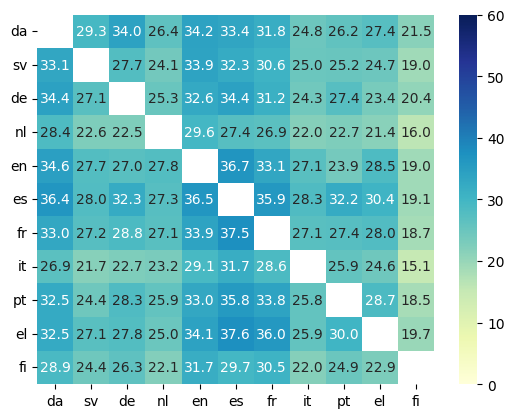

In [20]:
from scripts.presentation import Presenter
p1 = Presenter(results_folder='aligned_results_no_sent_split')
p1.show_score_matrices(foucus=['ep-gpt'])

ep-gpt


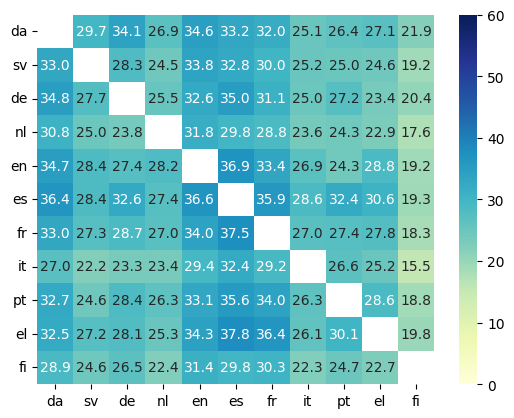

In [21]:
p2 = Presenter(results_folder='aligned_results_sent_split')
p2.show_score_matrices(foucus=['ep-gpt'])

### Difference between Alignments WITH and WITHOUT Sent Splits

In [ ]:
for x in p1.cases:
        df1 = p1.cases[x]['BLEU']
        df2 = p2.cases[x]['BLEU']
        
        diff = df1 - df2 
        print(x)
        diff_mean = diff.values.mean()
        
        diff_flat = diff.stack()
        top3_max = diff_flat.nlargest(15)
        print('Largest Positive Differences (Sent Splits made things worse)')
        for (s, t), score in top3_max.items():
            fn = f'{x}-{s}-{t}'
            no_sent_split = fn2align_cnt_no_sent_split[fn]
            sent_split = fn2align_cnt_sent_split[fn]
            print(f'{s}-{t}: {score:.1f} ({no_sent_split}->{sent_split})')
            
        top3_min = diff_flat.nsmallest(15)
        print('Largest Negative Differences (Sent Splits made things better)')
        for (s, t), score in top3_min.items():
            fn = f'{x}-{s}-{t}'
            no_sent_split = fn2align_cnt_no_sent_split[fn]
            sent_split = fn2align_cnt_sent_split[fn]
            print(f'{s}-{t}: {score:.1f} ({no_sent_split}->{sent_split})')
        print()


ep-deepl
Largest Positive Differences (Sent Splits made things worse)
da-es: 0.9 (395->383)
fr-fi: 0.4 (397->390)
fi-es: 0.3 (395->388)
Largest Negative Differences (Sent Splits made things better)
nl-fi: -2.5 (397->345)
nl-da: -2.5 (397->343)
nl-sv: -2.2 (395->333)
nl-en: -2.2 (397->339)
nl-pt: -2.1 (396->336)
nl-es: -2.0 (397->338)
nl-fr: -2.0 (397->339)
nl-de: -1.9 (397->342)
nl-it: -1.5 (397->328)
nl-el: -1.4 (397->339)

ep-gpt
Largest Positive Differences (Sent Splits made things worse)
sv-fr: 0.5 (395->351)
fr-fi: 0.4 (397->390)
fi-en: 0.3 (397->383)
Largest Negative Differences (Sent Splits made things better)
nl-es: -2.4 (397->338)
nl-sv: -2.4 (395->333)
nl-da: -2.4 (397->343)
nl-en: -2.2 (397->339)
nl-fr: -2.0 (397->338)
nl-it: -1.6 (397->329)
nl-fi: -1.6 (397->344)
nl-pt: -1.5 (396->335)
nl-el: -1.4 (397->339)
nl-de: -1.3 (397->342)

flores-deepl
Largest Positive Differences (Sent Splits made things worse)
sv-fi: 0.4 (397->423)
da-fi: 0.2 (394->428)
da-sv: 0.2 (394->418)
Larg

* In this case, Negative Differences refer to the case where Alignment WITH Sentence Splitting yielded higher BLEU scores than WITHOUT
* However, we can see based on alignment counts, that it may be not related to alignment but due to the fact that it works with less sentences overall.
* Additionally, the highest difference we observe is -2.5, not too tragic.

### Difference between Direct and Alignment WITHOUT Sent Splits
* 'Direct' means we just align directly based on line positions; assume that translator preserved alignment.

In [23]:
from scripts.presentation import Presenter
p3 = Presenter(results_folder='direct_results')

In [24]:
import json

mismatches = {}

with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)
    
for prefix, info in prefix2file.items():
    dataset, translator, s, t = prefix.split('-')
    key = f'{dataset}-{translator}'
    outlines = info['log']['out_lines']
    if outlines != 400:
        mismatches[prefix] = outlines

In [ ]:
for x in p1.cases:
        df1 = p3.cases[x]['BLEU']
        df2 = p1.cases[x]['BLEU']
        
        diff = df1 - df2 
        print(x)
        diff_mean = diff.values.mean()
        
        diff_flat = diff.stack()
        top3_max = diff_flat.nlargest(15)
        print('Largest Positive Differences (Alignment made things worse)')
        for (s, t), score in top3_max.items():
            fn = f'{x}-{s}-{t}'
            no_sent_split = fn2align_cnt_no_sent_split[fn]
            direct = fn2align_cnt_direct[fn]
            if fn in mismatches:
                mark = f'🛠️ ({mismatches[fn]}->{no_sent_split})'
            else:
                mark = ''
            print(f'{s}-{t}: {score:.1f} ({direct}->{no_sent_split}) {mark}')
            
        top3_min = diff_flat.nsmallest(15)
        print('Largest Negative Differences (Alignment made things better)')
        for (s, t), score in top3_min.items():
            fn = f'{x}-{s}-{t}'
            no_sent_split = fn2align_cnt_no_sent_split[fn]
            direct = fn2align_cnt_direct[fn]
            if fn in mismatches:
                mark = f'🛠️ ({mismatches[fn]}->{no_sent_split})'
            else:
                mark = ''
            print(f'{s}-{t}: {score:.1f} ({direct}->{no_sent_split}) {mark}')
        print()

ep-deepl
Largest Positive Differences (Alignment made things worse)
da-fi: 0.2 (400->395) 
sv-es: 0.2 (400->393) 
nl-sv: 0.1 (400->395) 
Largest Negative Differences (Alignment made things better)
da-el: -0.1 (400->395) 
sv-de: -0.0 (400->369) 
de-it: -0.0 (400->395) 
sv-fi: -0.0 (400->393) 
es-el: -0.0 (400->396) 
fr-el: 0.0 (400->396) 
es-it: 0.0 (400->397) 
en-el: 0.0 (400->397) 
nl-el: 0.0 (400->397) 
el-en: 0.0 (400->397) 
el-it: 0.0 (400->398) 
fi-el: 0.0 (400->397) 
it-el: 0.0 (400->398) 
es-en: 0.0 (400->396) 
de-el: 0.0 (400->397) 

ep-gpt
Largest Positive Differences (Alignment made things worse)
fr-nl: 0.1 (400->395) 
sv-de: 0.1 (400->383) 
de-sv: 0.1 (400->384) 
Largest Negative Differences (Alignment made things better)
es-en: -34.1 (399->397) 🛠️ (401->397)
de-en: -25.1 (398->394) 🛠️ (398->394)
de-fi: -15.6 (399->394) 🛠️ (399->394)
fi-nl: -15.4 (399->395) 🛠️ (399->395)
es-el: -15.0 (399->395) 🛠️ (399->395)
fi-it: -14.8 (399->394) 🛠️ (399->394)
el-it: -14.3 (399->396) 🛠️ (3

* If we compare Alignment WITHOUT Sentence Splitting to direct alignment, resp. no additional alignment, we observe that differences occur mainly where we assumed to a have mismatch anyway. 
* It is noteworthy that we see things like `399->400`, this occurs because `direct_alignment` excludes triplets where either source, reference or translation are missing. It means that after alignment, there was not anything that was missing because the alignment managed to fix that, the true counts from `translations` are added as well.
* It is also noteworthy that the biggest difference in aligned sent cnt, `sv-de: 400->369`,  had no difference in BLEU scores.

## LaBSE

* LaBSE alignments were computed in this notebook: [Alignments_No_Sent_Split_LaBSE.ipynb](https://colab.research.google.com/drive/1ieADAugVQ2nVq0Sqr9a299rsTjs9eMsB?usp=sharing)
* LaBSE is computationally more expensive and a bit trickier to use even with Google Colab; has issues with memory occasionally, however, since we used paraphrase-multilingual-MiniLM-L12-v2 for everything, we can now just compare it against LaBSE for the sentences that we plan to align for sure and see if it makes a big difference or not.

In [1]:
from scripts.post_process import post_triplet_align, load_aligned_sents_from_file
import os
src2hyp_split_fo = 'source2translations_no_sent_split_LaBSE'
filenames = [f.replace('.jsonl', '') for f in os.listdir(src2hyp_split_fo)]
len(filenames)

23

In [2]:
from scripts.data_management import EuroParlManager, FloresPlusManager, Opus100Manager

dms = {
    'ep': EuroParlManager(),
    'flores': FloresPlusManager(),
    'opus': Opus100Manager()
}

fn2align_cnt_no_sent_split_LaBSE = {}
fn2discard_no_sent_split_LaBSE = {}
cases = ['ep-gpt', 'ep-deepl', 'flores-gpt',
         'flores-deepl', 'opus-gpt', 'opus-deepl']
case2align_cnts_no_sent_split_LaBSE = {c: [] for c in cases}

for fn in filenames:
    dataset, translator, s, t = fn.split('-')
    src_sents_a, mt_sents_a = load_aligned_sents_from_file(
        fn, folder=src2hyp_split_fo)
    dm = dms[dataset]
    src_sents_o, ref_sents_o = dm.get_sentence_pairs(s, t, num_of_sents=400)
    align_cnt, dis = post_triplet_align(
        src_sents_org=src_sents_o,
        src_sents_ali=src_sents_a,
        ref_sents_org=ref_sents_o,
        mt_sents_ali=mt_sents_a,
        folder_path='aligned_triplets_no_sent_split_LaBSE',
        filename=fn)

    fn2align_cnt_no_sent_split_LaBSE[fn] = align_cnt
    fn2discard_no_sent_split_LaBSE[fn] = dis
    case2align_cnts_no_sent_split_LaBSE[f'{dataset}-{translator}'].append(align_cnt)


for t, ac in case2align_cnts_no_sent_split_LaBSE.items():
    if len(ac) == 0:
        continue
    max_cnt = max(ac)
    min_cnt = min(ac)
    mean = sum(ac) / len(ac)
    print(t)
    print(f'min: {min_cnt}')
    print(f'max: {max_cnt}')
    print(f'mean: {mean:.2f}')
    print()

ep-gpt
min: 393
max: 397
mean: 395.43

flores-gpt
min: 400
max: 400
mean: 400.00

opus-gpt
min: 372
max: 400
mean: 386.00



In [9]:
from scripts.post_process import load_aligned_sents_from_file
from scripts.scoring import compute_bleu
paraphrase = 'aligned_triplets_no_sent_split'
laBSE = 'aligned_triplets_no_sent_split_LaBSE'
filenames = [f.replace('.jsonl', '') for f in os.listdir(laBSE)]
diff_cnt = 0
total_diff = 0
max_diff = 0
min_diff = 100
for fn in filenames:
    ref_sents_p, mt_sents_p = load_aligned_sents_from_file(
        fn, folder=paraphrase, src_label='ref', tgt_label='mt')
    ref_sents_l, mt_sents_l = load_aligned_sents_from_file(fn, folder=laBSE,
                                                           src_label='ref', tgt_label='mt')
    bleu_p = compute_bleu(ref_sents_p, mt_sents_p)
    bleu_l = compute_bleu(ref_sents_l, mt_sents_l)
    print(fn)
    no_diff = bleu_l == bleu_p
    if no_diff:
        mark = ''
    else:
        mark = '❌'
        diff_cnt += 1
        total_diff += abs(bleu_l - bleu_p)
        max_diff = max(max_diff, abs(bleu_l - bleu_p))
        min_diff = min(min_diff, abs(bleu_l - bleu_p))
    print(f'BLEU Paraphrase: {bleu_p:.3f}')
    print(f'BLEU LaBSE: {bleu_l:.3f} {mark}')
    print(f'Difference: {not no_diff}')
    
print(f'Mean Difference: {total_diff/diff_cnt:.3f}')
print(f'Max Difference: {max_diff:.3f}')
print(f'Min Difference: {min_diff:.3f}')

ep-gpt-da-it
BLEU Paraphrase: 24.795
BLEU LaBSE: 24.795 
Difference: False
ep-gpt-de-en
BLEU Paraphrase: 32.615
BLEU LaBSE: 32.615 
Difference: False
ep-gpt-de-fi
BLEU Paraphrase: 20.383
BLEU LaBSE: 20.356 ❌
Difference: True
ep-gpt-el-it
BLEU Paraphrase: 25.872
BLEU LaBSE: 25.872 
Difference: False
ep-gpt-el-nl
BLEU Paraphrase: 25.019
BLEU LaBSE: 25.032 ❌
Difference: True
ep-gpt-en-fi
BLEU Paraphrase: 18.984
BLEU LaBSE: 18.984 
Difference: False
ep-gpt-es-el
BLEU Paraphrase: 30.407
BLEU LaBSE: 30.407 
Difference: False
ep-gpt-es-en
BLEU Paraphrase: 36.493
BLEU LaBSE: 36.493 
Difference: False
ep-gpt-es-nl
BLEU Paraphrase: 27.348
BLEU LaBSE: 27.348 
Difference: False
ep-gpt-fi-it
BLEU Paraphrase: 22.025
BLEU LaBSE: 22.025 
Difference: False
ep-gpt-fi-nl
BLEU Paraphrase: 22.121
BLEU LaBSE: 22.121 
Difference: False
ep-gpt-it-fi
BLEU Paraphrase: 15.083
BLEU LaBSE: 15.083 
Difference: False
ep-gpt-pt-fi
BLEU Paraphrase: 18.495
BLEU LaBSE: 18.495 
Difference: False
ep-gpt-sv-fi
BLEU Paraphr

* Using LaBSE does not make a big difference (exists but very small) for the aligned sentences that matter, thus we keep using paraphrase-multilingual-MiniLM-L12-v2
* Funnily enough, the differences occur mainly when Greek or Finnish is source/target

## Final Triplets
* To create our final set of triplets with which we work with from now on we just copy all direct results and swap the cases where there was a mismatch.

In [29]:
import os
from os.path import join
import shutil
direct_files = os.listdir('direct_triplets')

os.makedirs('final_triplets', exist_ok=True)
for fn in direct_files:
    name = fn.replace('.jsonl', '')
    if name not in mismatches:
        src_file = join('direct_triplets', fn)
    else:
        src_file = join('aligned_triplets_no_sent_split', fn)

    dst_file = join('final_triplets', fn)
    shutil.copy(src_file, dst_file)